# Yeezy Taught Me - Exploratory Analysis (Audio Features)

# Project imports

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import os
import sys
import time
import glob
import datetime
import sqlite3

Import useful methods that have been refactored out of this notebook:

In [2]:
# Load the "autoreload" extension
%load_ext autoreload

# always reload modules marked with "%aimport"
%autoreload 1

# add the 'src' directory as one where we can import modules
src_dir = os.path.join(os.getcwd(), os.pardir, 'src')
sys.path.append(src_dir)

# import my methods from the source code
%aimport Util
import Util

# Define file directories and imports to read Million Song Dataset files

In [3]:
# path to the Million Song Dataset subset (uncompressed)
# CHANGE IT TO YOUR LOCAL CONFIGURATION
msd_subset_path='../data/raw/MillionSongSubset'
msd_subset_data_path=os.path.join(msd_subset_path,'data')
msd_subset_addf_path=os.path.join(msd_subset_path,'AdditionalFiles')

# path to the Million Song Dataset code
# CHANGE IT TO YOUR LOCAL CONFIGURATION
msd_code_path='../src/MSongsDB/'

# we add some paths to python so we can import MSD code
path = os.path.join(msd_code_path,'PythonSrc')
if path not in sys.path:
    sys.path.append(path)

# imports specific to the MSD
import hdf5_getters as GETTERS

# Sanity checks

## Confirm the number of songs we have

In [4]:
# we define this very useful function to iterate the files
def apply_to_all_files(basedir,func=lambda x: x,ext='.h5'):
    """
    From a base directory, go through all subdirectories,
    find all files with the given extension, apply the
    given function 'func' to all of them.
    If no 'func' is passed, we do nothing except counting.
    INPUT
       basedir  - base directory of the dataset
       func     - function to apply to all filenames
       ext      - extension, .h5 by default
    RETURN
       number of files
    """
    cnt = 0
    # iterate over all files in all subdirectories
    for root, dirs, files in os.walk(basedir):
        files = glob.glob(os.path.join(root,'*'+ext))
        # count files
        cnt += len(files)
        # apply function to all files
        for f in files :
            func(f)       
    return cnt

# we can now easily count the number of files in the dataset
print apply_to_all_files(msd_subset_path), 'song files out of 10000!'


10001 song files out of 10000!


**Wait...10,001 songs? Okay.**

## Get all the artist names into a unique set

In [5]:
all_artist_names = set()

# we define the function to apply to all files
def func_to_get_artist_name(filename):
    """
    This function does 3 simple things:
    - open the song file
    - get artist ID and put it
    - close the file
    """
    h5 = GETTERS.open_h5_file_read(filename)
    artist_name = GETTERS.get_artist_name(h5)
    all_artist_names.add( artist_name )
    h5.close()
    
# let's apply the previous function to all files
# we'll also measure how long it takes
t1 = time.time()
apply_to_all_files(msd_subset_data_path,func=func_to_get_artist_name)
t2 = time.time()
print 'All artist names extracted in:', Util.strtimedelta(t1, t2)

All artist names extracted in: 0:01:08.195758


## Is Ye in the set of artist names?

In [6]:
if 'Kanye West' in all_artist_names:
    print 'Yes, he is!'
else:
    'Oh, no!'

Yes, he is!


## How many unique artists are there?

In [7]:
print 'Found', len(all_artist_names), 'unique artist names'

Found 4412 unique artist names


# Reading in the dataset as a sqlite database

In addition the the HDF5 files, there are some useful sqlite databases under assets/data/MillionSongSubset/AdditionalFiles. The following sqlite database files are available:

- subset_artist_similarity.db
- subset_artist_term.db
- subset_track_metadata.db

In [8]:
ARTIST_SIMILARITY_DB = 'subset_artist_similarity.db'
ARTIST_TERM_DB       = 'subset_artist_term.db'
TRACK_METADATA_DB    = 'subset_track_metadata.db'

## Read in subset_track_metadata.db

In [9]:
query = "SELECT * FROM songs WHERE artist_name LIKE '%Kanye%'"
df = Util.execute_query(msd_subset_addf_path, TRACK_METADATA_DB, query)
df.head()

,track_id,title,song_id,release,artist_id,artist_mbid,artist_name,duration,artist_familiarity,artist_hotttnesss,year
0,TRAIYZW128F9330F7D,Street Lights,SOJMUAN12AB0183911,808s & Heartbreak,ARRH63Y1187FB47783,164f0d73-1234-4e2c-8743-d77bf2191051,Kanye West,189.96200,0.877214,1.082503,2008
1,TRAIACZ128F428C60A,Heard 'Em Say,SOCVLYM12A8C13A799,Heard 'Em Say,ARRH63Y1187FB47783,164f0d73-1234-4e2c-8743-d77bf2191051,Kanye West / Adam Levine,204.51220,0.877214,1.082503,2005
2,TRAXDML128E079159C,Gone,SORUAXY12A67020A4B,Late Registration,ARRH63Y1187FB47783,164f0d73-1234-4e2c-8743-d77bf2191051,Kanye West / Consequence / Cam'Ron,333.34812,0.877214,1.082503,2005
3,TRAYXDI128F428CD9C,Skit #2 (Kanye West/Late Registration),SOLAWQF12A58A7B176,Late Registration,ARRH63Y1187FB47783,164f0d73-1234-4e2c-8743-d77bf2191051,Kanye West,31.32036,0.877214,1.082503,2005
4,TRADMUH128F146D3CD,Through The Wire,SOGWZBN12A6D4F6AB2,Through The Wire,ARRH63Y1187FB47783,164f0d73-1234-4e2c-8743-d77bf2191051,Kanye West,271.25506,0.877214,1.082503,2003


** Looks like the artist_id of Kanye West is ARRH63Y1187FB47783 - this will probably be useful to note. **

In [10]:
KANYE_WEST_ARTIST_ID = 'ARRH63Y1187FB47783'

### How many Kanye songs do we have in this dataset?

In [11]:
query = "SELECT * FROM songs WHERE artist_id = '{0}'".format(KANYE_WEST_ARTIST_ID)
kanye_west_songs = Util.execute_query(msd_subset_addf_path, TRACK_METADATA_DB, query)
print 'There are', len(kanye_west_songs), 'Kanye West songs!'

There are 9 Kanye West songs!


### What genres are available in this dataset?

In [12]:
def search_genre(genre_name):
    query = "SELECT DISTINCT term FROM terms WHERE term LIKE '%{0}%'".format(genre_name)
    df = Util.execute_query(msd_subset_addf_path, ARTIST_TERM_DB, query)
    print len(df), 'related', genre_name, 'terms available'
    print '\nFirst 5 terms found...'
    print df.head()

In [13]:
search_genre('rap')

65 related rap terms available

First 5 terms found...
              term
0     abstract rap
1         acid rap
2  alternative rap
3     american rap
4       battle rap


In [14]:
search_genre('hip hop')

47 related hip hop terms available

First 5 terms found...
                  term
0          90s hip hop
1     abstract hip hop
2      african hip hop
3  alternative hip hop
4     canadian hip hop


In [15]:
search_genre('hip-hop')

1 related hip-hop terms available

First 5 terms found...
             term
0  danish hip-hop


In [16]:
search_genre('trap')

0 related trap terms available

First 5 terms found...
Empty DataFrame
Columns: [term]
Index: []


**Ayyy...where Atlanta at? We might need to hit up the Spotify API to get newer songs after all!**

In [17]:
search_genre('pop')

143 related pop terms available

First 5 terms found...
              term
0          00s pop
1          60s pop
2          70s pop
3          80s pop
4  80s pop espanol


**Looks like we have a ton of rap/hip hop related genres (terms)!** 😬


# Data cleanup

## Read in the processed song features dataset

All songs that have the same artist term's as Kanye's were compiled into `song_features_df`. See **/src/data/make_song_features_df.py** for the ETL script on how this was done.

In [18]:
song_features_df = pd.read_pickle('../data/interim/msd_subset_song_features_df.pkl')
song_features_df.head()

,analysis_sample_rate,artist_7digitalid,artist_familiarity,artist_hotttnesss,artist_id,artist_latitude,artist_location,artist_longitude,artist_mbid,artist_mbtags,...,tatums_confidence,tatums_start,tempo,time_signature,time_signature_confidence,title,track_7digitalid,track_id,year,lyrics
0,22050,29785,0.780462,0.574275,ARMQHX71187B9890D3,NaN,"Atlanta, GA",NaN,bc5e2ad6-0a4a-4d90-b911-e9a7e6861727,"[heavy metal, sludge metal, progressive metal,...",...,"[0.562, 0.556, 0.499, 0.447, 0.392, 0.337, 0.2...","[0.15143, 0.30597, 0.4628, 0.61963, 0.77647, 0...",173.205,5,0.120,Deep Sea Creature,2442524,TRACCVZ128F4291A8A,2001,What you're feeling is pressure\nPulsate new b...
1,22050,7725,0.687687,0.406686,ARDI88R1187B98DAB2,NaN,,NaN,fd87374e-ffde-4d36-89a8-8a073f795666,[],...,"[0.262, 0.258, 0.24, 0.206, 0.185, 0.172, 0.14...","[0.19336, 0.51915, 0.84334, 1.16752, 1.48687, ...",93.056,4,1.000,If I...,507029,TRACCSW128F148C7C3,0,"Brooklyn, Brook-lyn, take it back, take it bac..."
2,22050,74269,0.593416,0.395710,ARZEWUR1187FB53DC8,50.45663,"Belgica -- Namur, Namur/Ghent, East Flanders",4.87137,0be59867-0da4-4e45-9b64-728cdf25487c,[],...,"[0.16, 0.152, 0.143, 0.134, 0.124, 0.112, 0.10...","[0.19525, 0.41527, 0.63418, 0.8542, 1.07973, 1...",90.660,3,0.524,Ad Te Clamamus Exsvles Mortva Liberi,8688607,TRACCVS12903D014F8,2010,
3,22050,49956,0.815923,0.555138,ARUZRFN1187B98AC05,NaN,"Cleveland, OH",NaN,2fa45bbb-0efb-4950-9d40-94bf23cbfec1,[],...,"[0.575, 0.572, 0.579, 0.58, 0.579, 0.582, 0.58...","[0.27452, 0.46673, 0.66389, 0.86798, 1.06691, ...",101.167,1,1.000,Murder One,3510188,TRACCKS128F42B77AE,2000,We in the last five days of these trials and t...
4,22050,25694,0.543937,0.430300,ARHBWOZ1187FB3FD53,NaN,ITALY,NaN,e6ff2839-5ccb-451b-b07e-f485bc143118,[],...,"[0.775, 0.763, 0.756, 0.713, 0.664, 0.61, 0.57...","[0.09718, 0.28554, 0.4739, 0.66132, 0.84874, 1...",173.841,3,0.302,On My Feet Again,6389516,TRACCQM12903CACC1E,0,


## Create flag `is_kanye_song` 

In [22]:
def is_kanye_song(artist_id):
    if artist_id == KANYE_WEST_ARTIST_ID:
        return 1
    else:
        return 0

song_features_df['is_kanye_song'] = song_features_df['artist_id'].apply(is_kanye_song)

## Clean up some features

Calculate the count of beats, bars, sections, segments, and tatums instead of trying to handle the numpy matrices:

In [23]:
song_features_df['total_beats'] = song_features_df['beats_start'].apply(len)
song_features_df['total_bars'] = song_features_df['bars_start'].apply(len)
song_features_df['total_sections'] = song_features_df['sections_start'].apply(len)
song_features_df['total_segments'] = song_features_df['segments_start'].apply(len)
song_features_df['total_tatums'] = song_features_df['tatums_start'].apply(len)

# Exploratory analysis

As the entire Million Song Dataset comes in at 300 GB and I do not currently have the infrastructure in place to handle the full set of data yet, I will be using the [Million Song Subset](http://labrosa.ee.columbia.edu/millionsong/pages/getting-dataset) for the exploratory analysis phase of the project.

The Million Song Subset consists of 10,000 songs (1%, 1.8 GB) selected at random.

The above `song_features_df` dataframe was the result of joining all the H5 files from the Million Song Dataset (MSD) using the ETL scripts triggered by the `make data` command.

## Feature densities

For each feature, let's see how its values are distributed:

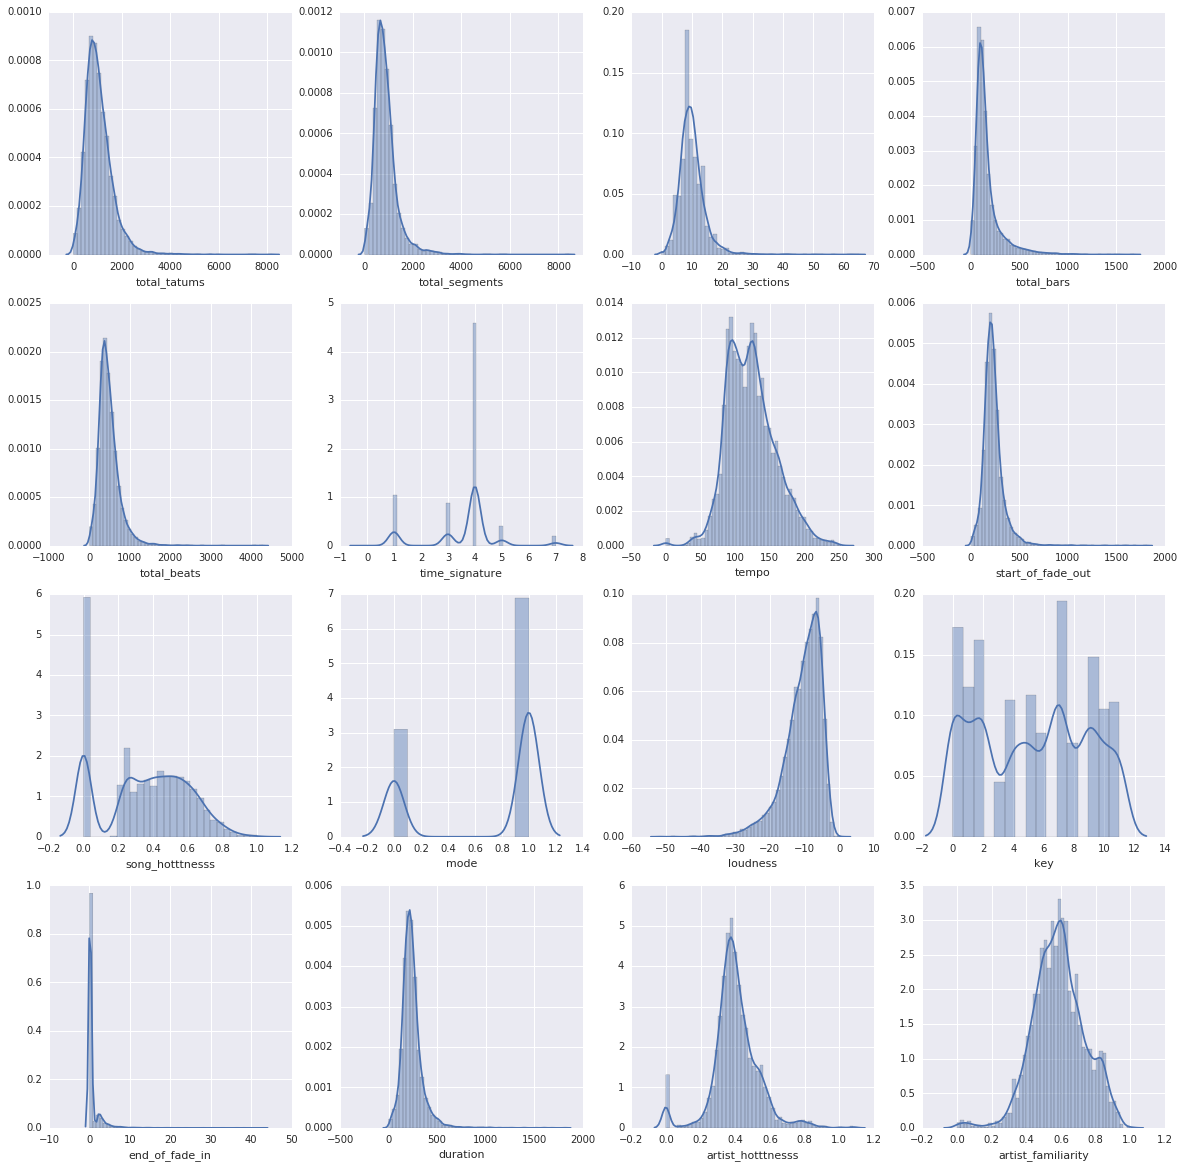

In [54]:
num_rows = 4
num_cols = 4

cols_to_plot = ['artist_familiarity', 'artist_hotttnesss', 'duration',
                'end_of_fade_in', 'key', 'loudness',
                'mode', 'song_hotttnesss', 'start_of_fade_out',
                'tempo', 'time_signature', 'total_beats',
                'total_bars', 'total_sections', 'total_segments',
                'total_tatums']

f, axes = plt.subplots(num_rows, num_cols, figsize=(20, 20), sharex=False)

for i in range(num_rows):
    for j in range(num_cols):
        if len(cols_to_plot) != 0:
            var = cols_to_plot.pop()
            data = song_features_df[var].dropna()
            if data.dtype == np.ndarray:
                data = data.map(len)
            sns.distplot(data, ax=axes[i, j])

## Relationships between variables

I do not expect significant correlations between our variables for audio features, but it's worth a shot...

In [42]:
cols_to_plot = ['artist_familiarity', 'artist_hotttnesss', 'duration',
                'end_of_fade_in', 'key', 'loudness',
                'mode', 'song_hotttnesss', 'start_of_fade_out',
                'tempo', 'time_signature', 'total_beats',
                'total_bars', 'total_sections', 'total_segments',
                'total_tatums']

features_to_consider = song_features_df[cols_to_plot]

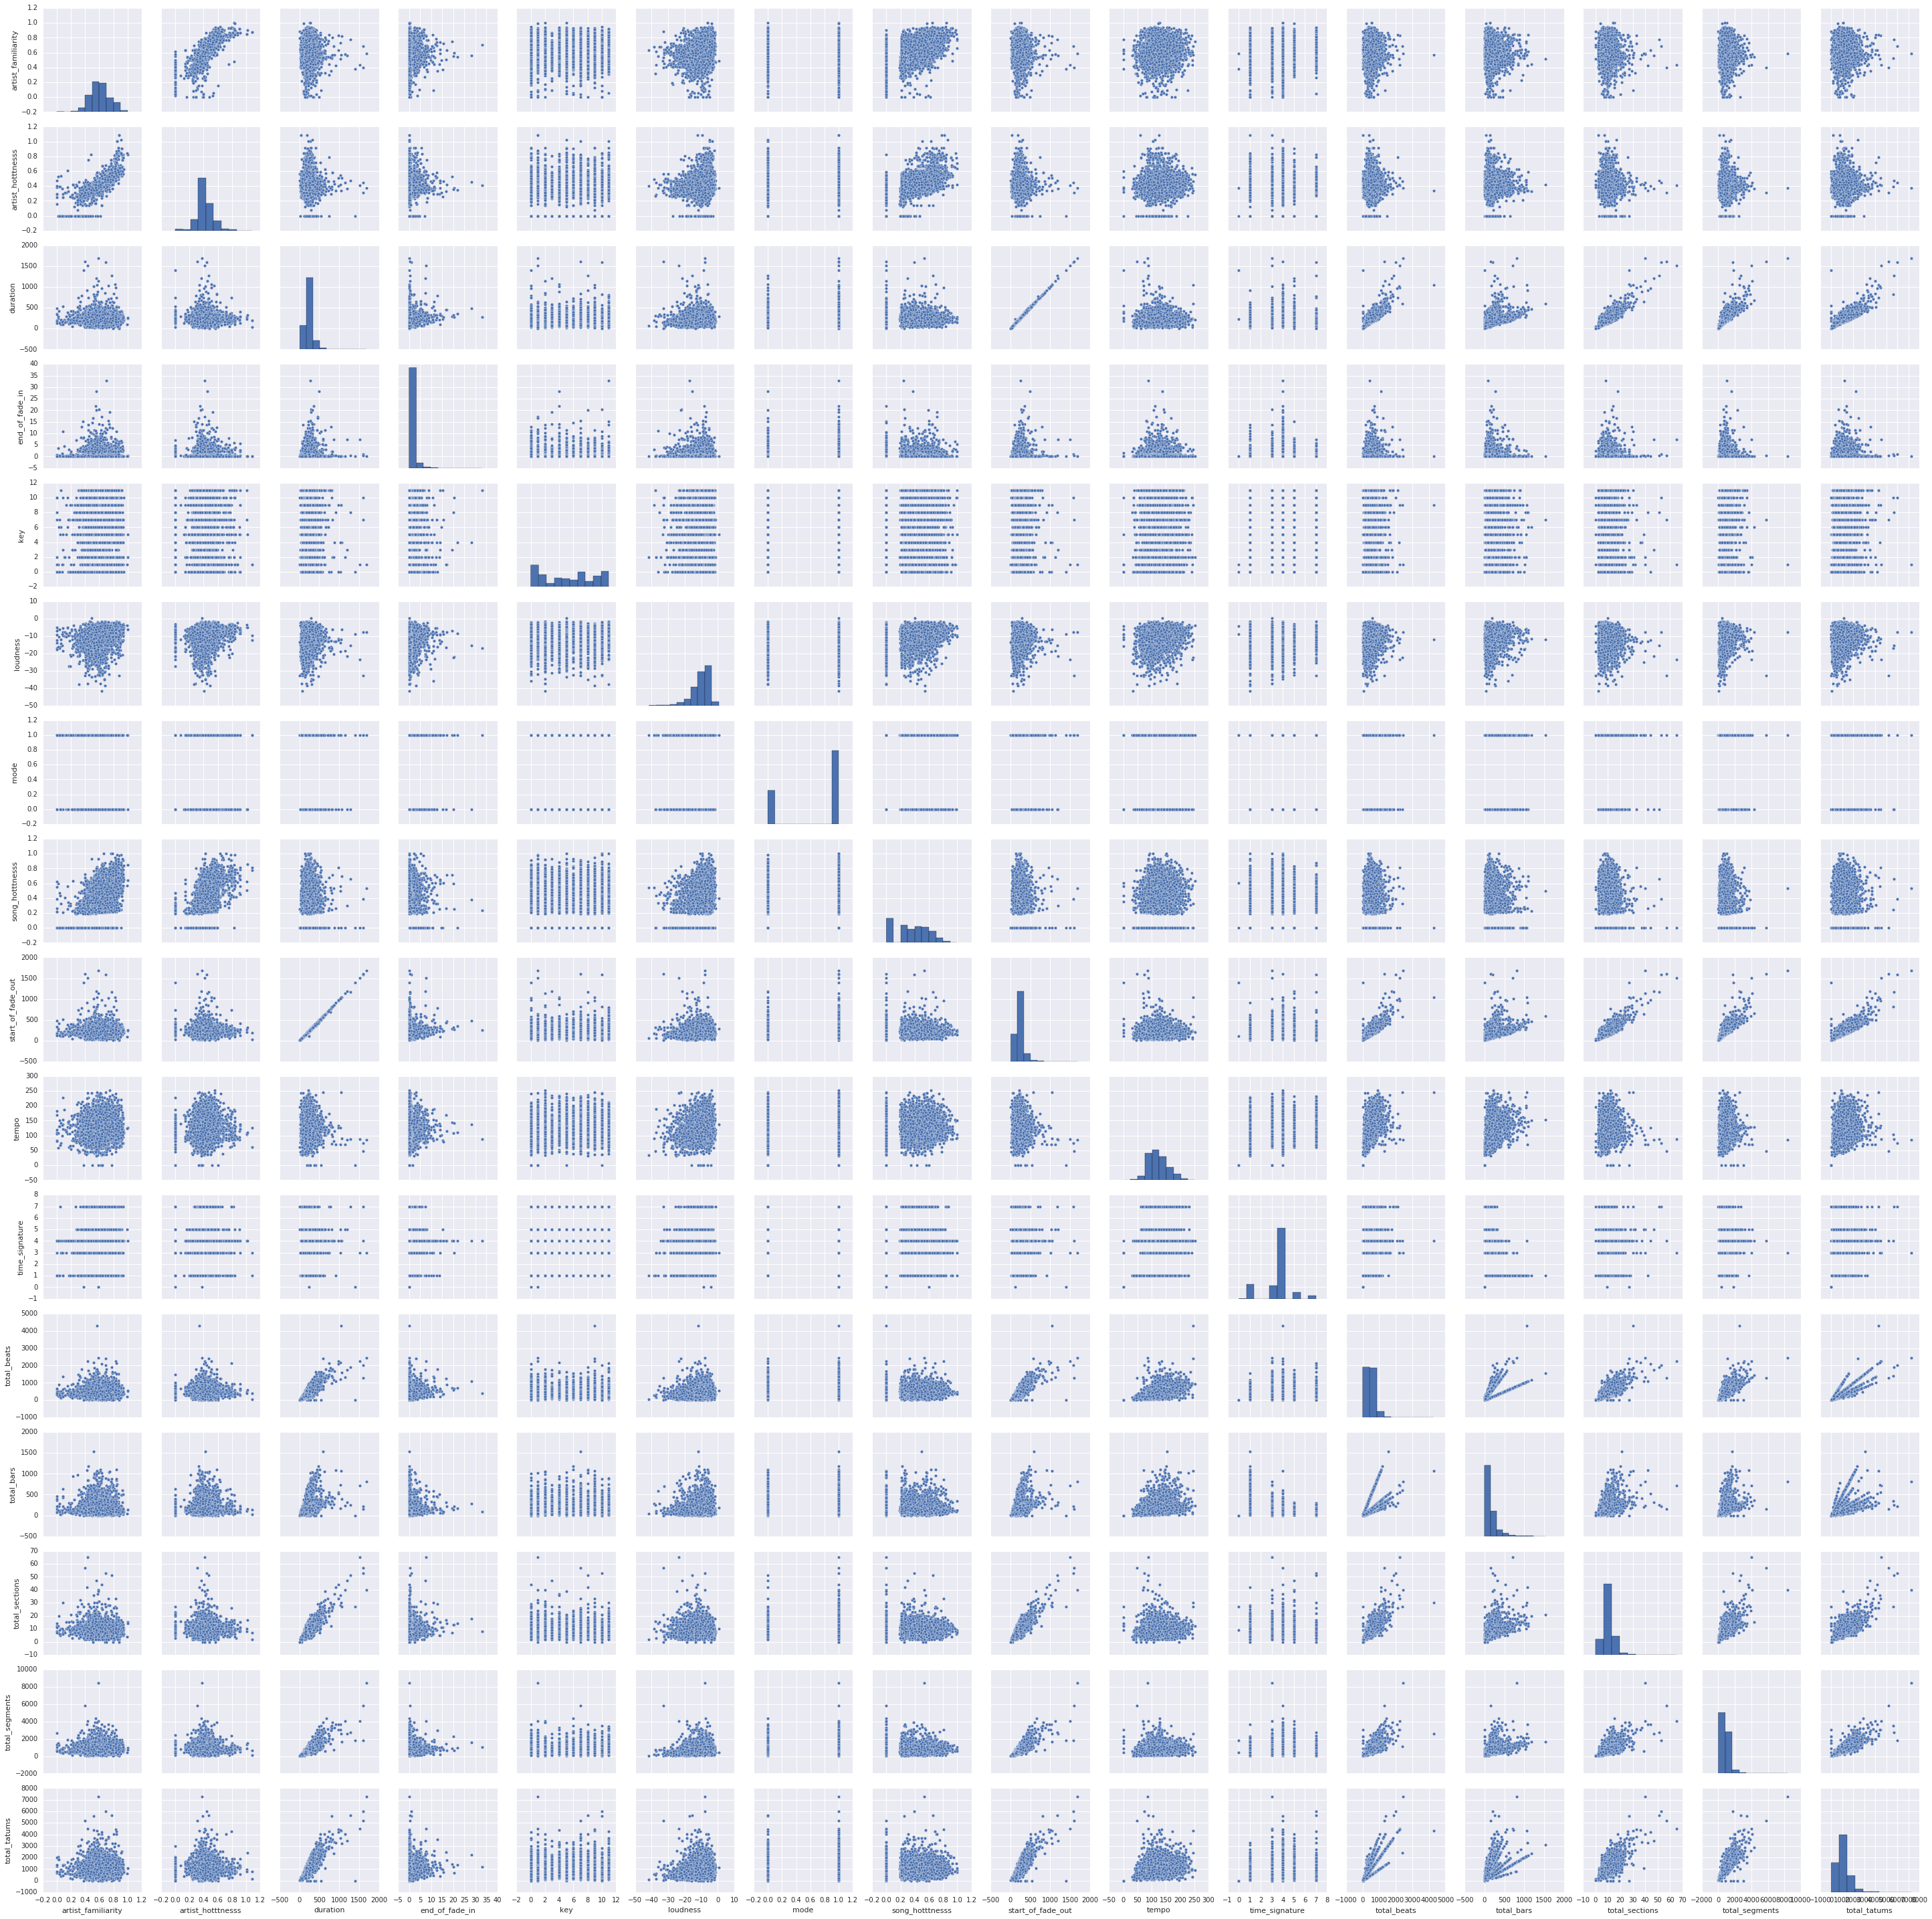

In [43]:
sns.pairplot(features_to_consider.dropna())

## Takeaways

Looks interesting, but without knowing what to expect, it's hard to say if there's is any value of looking at the distribution and densities of the song features at face value. However, we at least know that the distributions of most feature values are not necessarily guassian or uni-modal, and that several only exist on a discrete scale (e.g. `key`, `mode`, and `time_signature`).

As previously assumed, I will need to use classification algorithms to discover groups of related artists.


# Principal Component Analysis (PCA)

In order to emphasize variation and bring out strong patterns in the dataset, I will run a Principal Component Analysis to see what insights come up.

In [44]:
import sklearn
from sklearn import decomposition

Prep features that are not of type np.ndarray since pca.fit() does not like that:

In [45]:
mask = features_to_consider.dtypes != np.object
features_to_reduce = features_to_consider.loc[:, mask]
features_to_reduce = features_to_reduce.dropna()

Now run the PCA:

In [46]:
pca = decomposition.PCA(n_components=4)
pca.fit(features_to_reduce)
X = pca.transform(features_to_reduce)
print pca.explained_variance_ratio_

[ 0.85436726  0.08258382  0.03537687  0.01869889]


## Explained variance ratio

Using PCA, we reduced the total number of dimensions into two dimensions (or principal components). It appears that the first three PCA variables captures most of the variance in the data.

## Plot the Principal Components

In [47]:
X1 = pca.components_[0]
X2 = pca.components_[1]
X3 = pca.components_[2]
X4 = pca.components_[3]

Principal component 1 (PC1):

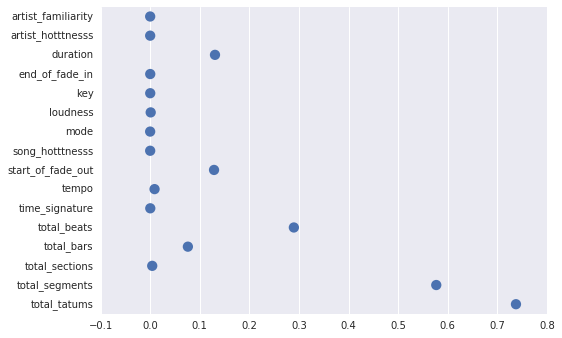

In [48]:
sns.pointplot(x=X1, y=list(features_to_reduce.columns.values), join=False)

Principal component 2 (PC2):

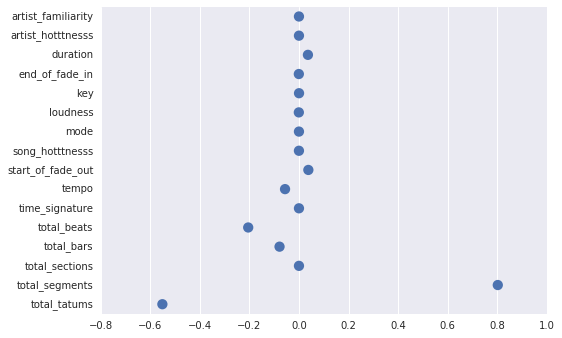

In [49]:
sns.pointplot(x=X2, y=list(features_to_reduce.columns.values), join=False)

Principal component 3 (PC3):

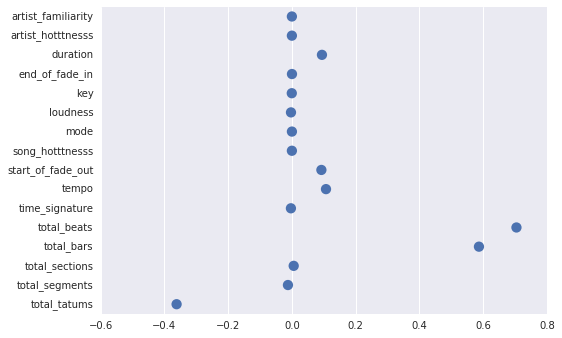

In [50]:
sns.pointplot(x=X3, y=list(features_to_reduce.columns.values), join=False)

Principal component 4 (PC4):

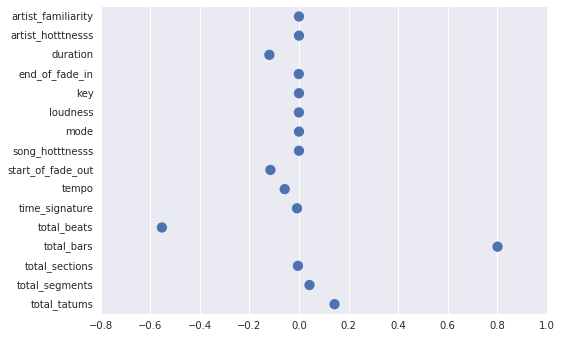

In [51]:
sns.pointplot(x=X4, y=list(features_to_reduce.columns.values), join=False)

PC1 x PC2 x PC3 x PC4:

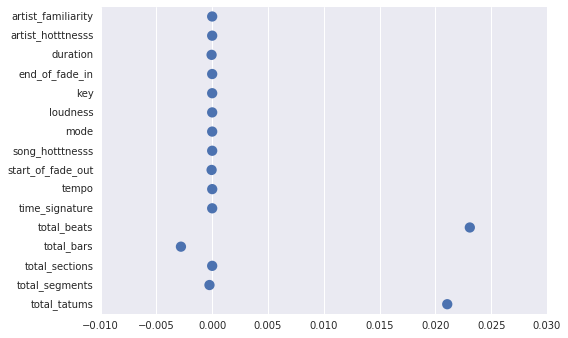

In [52]:
sns.pointplot(x=(X1 * X2 * X3 * X4), y=list(features_to_reduce.columns.values), join=False)

By plotting the principal components we see that there is significant variance for `total_beats`, `total_bars`, and `total_tatums`. There is also some variance for `total_segments`. There isn't a good amount of variance for `tempo`, `loudness`, etc. as I would imagine most songs we pulled would have similair features as they belong in the same terms/genres as Kanye West.

# Export data

Export our current DataFrame so we can perform modeling in our next notebook.

In [40]:
# Uncomment line below to export
# song_features_clean_df.to_pickle('../data/processed/msd_subset_song_features_clean_df.pkl')